In [15]:
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm 
from random import shuffle
from sklearn.model_selection import train_test_split
import keras 

# packages for LeNet
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.regularizers import l2

%matplotlib inline 

### Get raw data

In [10]:
# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Training and testing folder
TRAIN_DIR = 'dataset/train'
TEST_DIR = 'dataset/test'
IMG_SIZE = 96

# Remove [:1000] to use all images in train folder
X_train = os.listdir(TRAIN_DIR)[:1000]

In [11]:
def label_img(img):
    '''
    Read image path and parses out 'cat' and 'dog'; Returns 1 if cat, 0 if pupper doggo
    '''
    
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]

In [12]:
def create_train_data():
    '''
    Creates the dataset for training in the required format
    
    Outputs a list of images
    '''
    training_data = []
    for img in tqdm(X_train):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    # shuffle all images to avoid biasness toward a particular class
    shuffle(training_data)
    
    return training_data

In [5]:
# Generate labels for the data

labels = []
for i in X_train:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

Text(0.5, 1.0, 'Cats and Dogs')

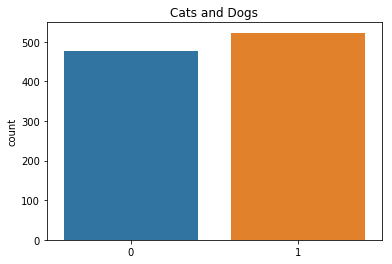

In [6]:
sns.countplot(labels)
plt.title('Cats and Dogs')

### Create training

In [7]:
train = create_train_data()
print("Done!")

100%|██████████| 1000/1000 [00:12<00:00, 82.24it/s]

Done!


In [9]:
# Convert training data to numpy array
training_images = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)

# Convert training labels to numpy array
training_labels= np.array([i[1] for i in train])

training_images.shape, training_labels.shape

((1000, 96, 96, 3), (1000, 2))

In [10]:
x_train, x_test, y_train, y_test = train_test_split(training_images, training_labels, test_size=0.1, random_state=42)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(900, 96, 96, 3) (900, 2) (100, 96, 96, 3) (100, 2)


### Save the training data for future use

In [18]:
np.save("x_train.npy",x_train)
np.save("x_test.npy",x_test)
np.save("y_train.npy",y_train)
np.save("y_test",y_test)

### Load the training data

In [5]:
x_train = np.load("x_train.npy")
x_test = np.load("x_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(900, 96, 96, 3) (900, 2) (100, 96, 96, 3) (100, 2)


Such a good boi!


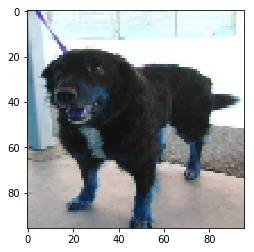

In [6]:
plt.imshow(x_train[502])
print("Such a good boi!")

In [16]:
def lenet_model(img_shape=(96, 96, 3), n_classes=2, l2_reg=0., weights=None):

    # Initialize model
    lenet = Sequential()

    # 2 sets of CRP (Convolution, RELU, Pooling)
    lenet.add(Conv2D(20, (5, 5), padding="same",
        input_shape=img_shape, kernel_regularizer=l2(l2_reg)))
    lenet.add(Activation("relu"))
    lenet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    lenet.add(Conv2D(50, (5, 5), padding="same",
        kernel_regularizer=l2(l2_reg)))
    lenet.add(Activation("relu"))
    lenet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Fully connected layers (w/ RELU)
    lenet.add(Flatten())
    lenet.add(Dense(500, kernel_regularizer=l2(l2_reg)))
    lenet.add(Activation("relu"))

    # Softmax (for classification)
    lenet.add(Dense(n_classes, kernel_regularizer=l2(l2_reg)))
    lenet.add(Activation("softmax"))
    
    if weights is not None:
        lenet.load_weights(weights)
    
    lenet.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    # Return the constructed network
    return lenet


In [17]:
# Create LeNet model
model = lenet_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 96, 96, 20)        1520      
_________________________________________________________________
activation_9 (Activation)    (None, 96, 96, 20)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 20)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 48, 50)        25050     
_________________________________________________________________
activation_10 (Activation)   (None, 48, 48, 50)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 50)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 28800)             0         
__________

* https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
* https://github.com/eweill/keras-deepcv/blob/master/models/classification/lenet.py
* https://sgugger.github.io/what-is-deep-learning.html#what-is-deep-learning

### Train 

In [21]:
batch_size = 128
epochs = 20

In [22]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))

Train on 900 samples, validate on 100 samples
Epoch 1/20
900/900 [==============================] - 24s 27ms/step - loss: 8.3814 - acc: 0.4800 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 2/20
900/900 [==============================] - 28s 32ms/step - loss: 8.3814 - acc: 0.4800 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 3/20
900/900 [==============================] - 26s 28ms/step - loss: 8.3814 - acc: 0.4800 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 4/20
896/900 [============================>.] - ETA: 0s - loss: 8.4008 - acc: 0.4788

KeyboardInterrupt: 